# Metric analysis

The folowing notebook presents **statistical** and **machine learning based** methods to analyze and select the most meaningfull features that predict the human score within a dataset of metrics

### TODO


https://chatgpt.com/c/67963c90-aca8-8001-8479-7efaac72c1ba

### Loading

In [21]:
from datasets import load_dataset

df = load_dataset(
    "CharlyR/varbench-metric-evaluation", "treated", split="train"
).to_pandas()
df = df[
    [col_name for col_name in df.columns if "Metric" in col_name or "human_score" in col_name]
]

Generating train split: 100%|██████████| 15/15 [00:00<00:00, 2781.25 examples/s]


### Statistical-based analysis

#### correlation

<Axes: >

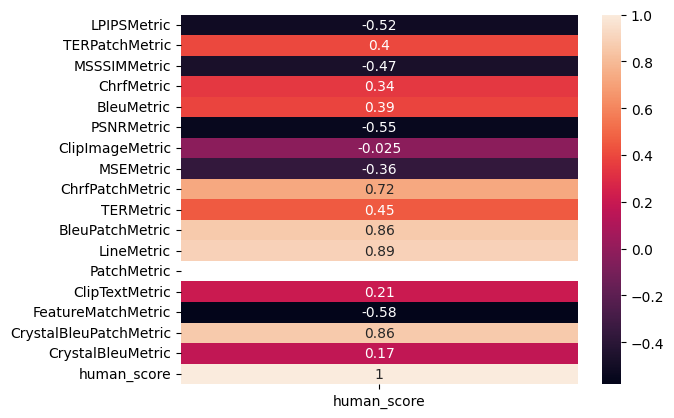

In [22]:
import seaborn as sns

corr = df.corr("spearman")
sns.heatmap(corr[["human_score"]],annot=True)

<Axes: >

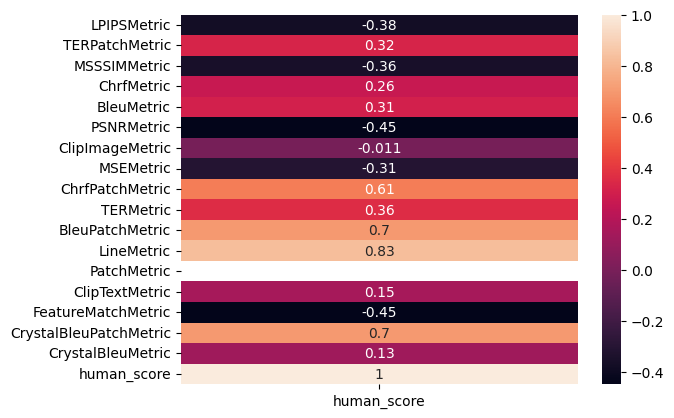

In [24]:
import seaborn as sns

corr = df.corr("kendall")
sns.heatmap(corr[["human_score"]],annot=True)

#### Univariate Feature Selection

ANOVA,F-Test and mutual information 


=> ANOVA finds linear dependencies between features, using comparisons between mean and variances between groups ( a feature has more predictive power if its group's means are separated and the variances of these groups are low), F-test is the same as ANOVA with means only
=> Mutual Information uses entropy: I(x,y) = H(y) - H(y|x) 


Notes: Chi2, ANOVA and F-tests are more relevant for categorical features

In [25]:
from sklearn.model_selection import train_test_split

#X(features) are the metrics
X = df.drop("human_score",axis=1)
#Y is the human score
y = df["human_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123456)


In [30]:
from sklearn.feature_selection import (
    f_classif,
    f_regression,
    mutual_info_regression,
    chi2,
    SelectKBest,
)
import numpy as np


def compute_scores(feature_selection_alg):
    selector = SelectKBest(feature_selection_alg, k="all")
    selector.fit(X_train, y_train)
    #scores = -np.log10(selector.pvalues_)
    scores = selector.scores_
    #scores /= scores.max()
    return scores


ANOVA_scores = compute_scores(f_classif)
f_test_scores = compute_scores(f_regression)
mutual_info_scores = compute_scores(mutual_info_regression)
chi2_scores = compute_scores(chi2)

/home/creux/miniconda3/envs/metricbench/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/creux/miniconda3/envs/metricbench/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [29]:
chi2_scores

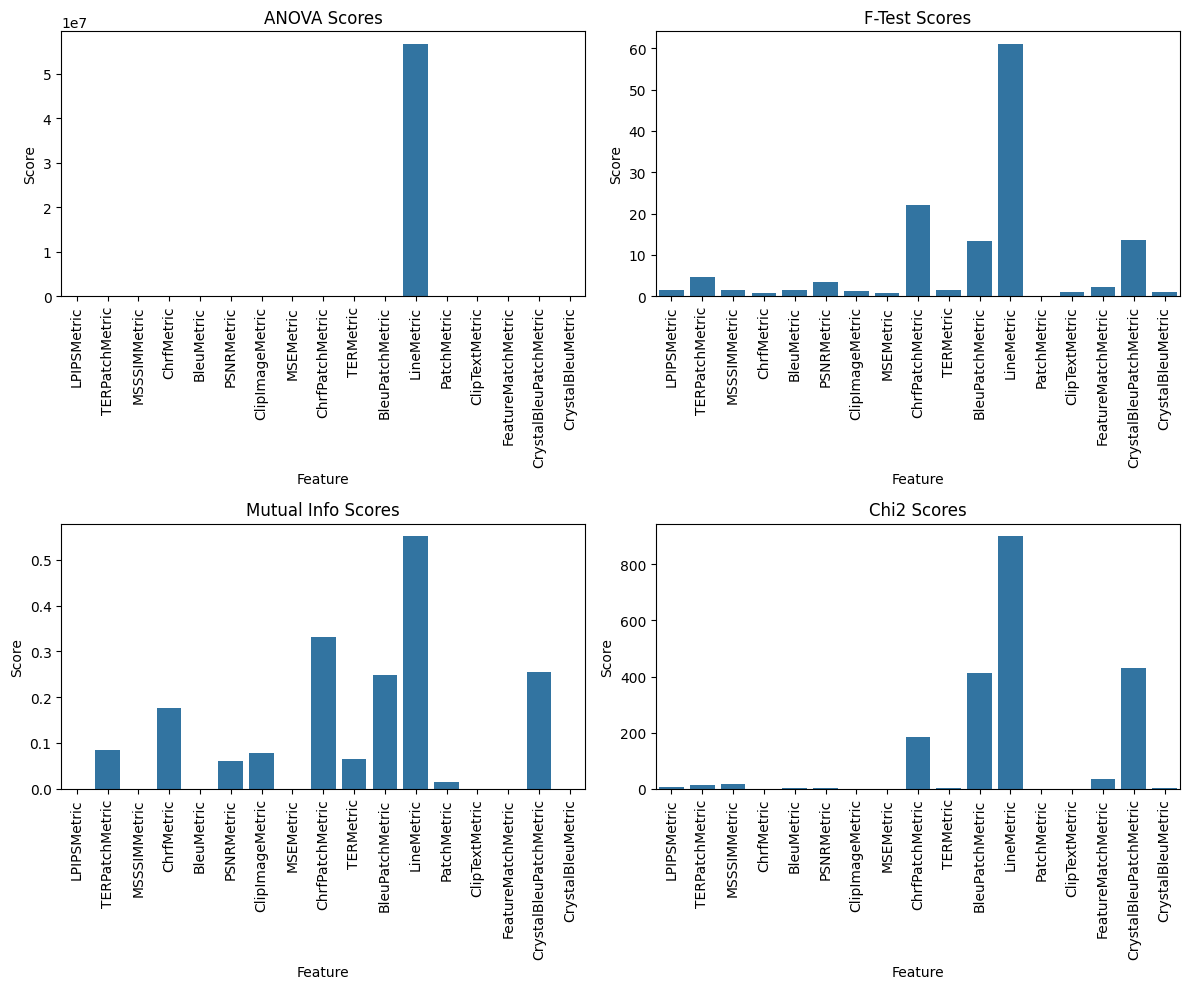

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_train is a DataFrame
feature_names = X_train.columns

# Creating a DataFrame for visualization
data = pd.DataFrame({
    'Feature': feature_names,
    'ANOVA': ANOVA_scores,
    'F-Test': f_test_scores,
    'Mutual Info': mutual_info_scores,
    'Chi2': chi2_scores
})

# Melting DataFrame for Seaborn
melted_data = data.melt(id_vars=['Feature'], var_name='Method', value_name='Score')

# Plot each method separately
methods = ['ANOVA', 'F-Test', 'Mutual Info', 'Chi2']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, method in enumerate(methods):
    sns.barplot(x='Feature', y='Score', data=melted_data[melted_data['Method'] == method], ax=axes[i])
    axes[i].set_title(f'{method} Scores')
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



### Model-based feature selection

#### RFE(Recursive Feature Elimination) with cross-validation for ordinal outputs

Notes on ridge regression:

In [43]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

min_features_to_select = 1 
rf = RandomForestClassifier(n_estimators=100, random_state=42)
cv = StratifiedKFold(5)
rfecv = RFECV(
    estimator=rf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X, y)

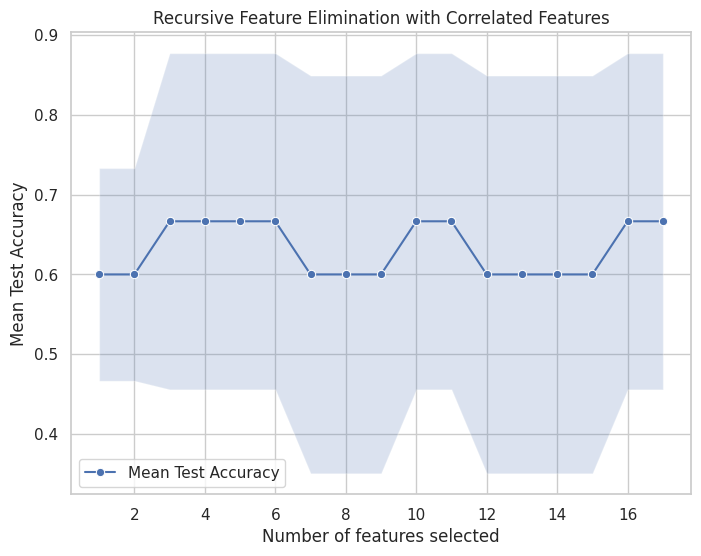

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame from RFECV results
cv_results = pd.DataFrame(rfecv.cv_results_)

# Set Seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(8, 6))
sns.lineplot(
    x=cv_results["n_features"], 
    y=cv_results["mean_test_score"], 
    marker="o", 
    label="Mean Test Accuracy")

# Add error bars
plt.fill_between(
    cv_results["n_features"],
    cv_results["mean_test_score"] - cv_results["std_test_score"],
    cv_results["mean_test_score"] + cv_results["std_test_score"],
    alpha=0.2
)

# Labels and title
plt.xlabel("Number of features selected")
plt.ylabel("Mean Test Accuracy")
plt.title("Recursive Feature Elimination using Random Forest Tree")
plt.legend()
plt.show()

In [57]:
rankings = rfecv.ranking_
feature_names = rfecv.feature_names_in_
feature_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Rank': rankings
})
sorted_feature_ranking = feature_ranking.sort_values(by='Rank')
print("Features ordered by rank:")
print(sorted_feature_ranking)

Features ordered by rank:
                   Feature  Rank
10         BleuPatchMetric     1
15  CrystalBleuPatchMetric     1
8          ChrfPatchMetric     1
11              LineMetric     2
1           TERPatchMetric     3
0              LPIPSMetric     4
7                MSEMetric     5
14      FeatureMatchMetric     6
16       CrystalBleuMetric     7
9                TERMetric     8
3               ChrfMetric     9
4               BleuMetric    10
2             MSSSIMMetric    11
6          ClipImageMetric    12
5               PSNRMetric    13
13          ClipTextMetric    14
12             PatchMetric    15


#### Permutation importance using RandomForest, Logistic ordinal regression and Ridge

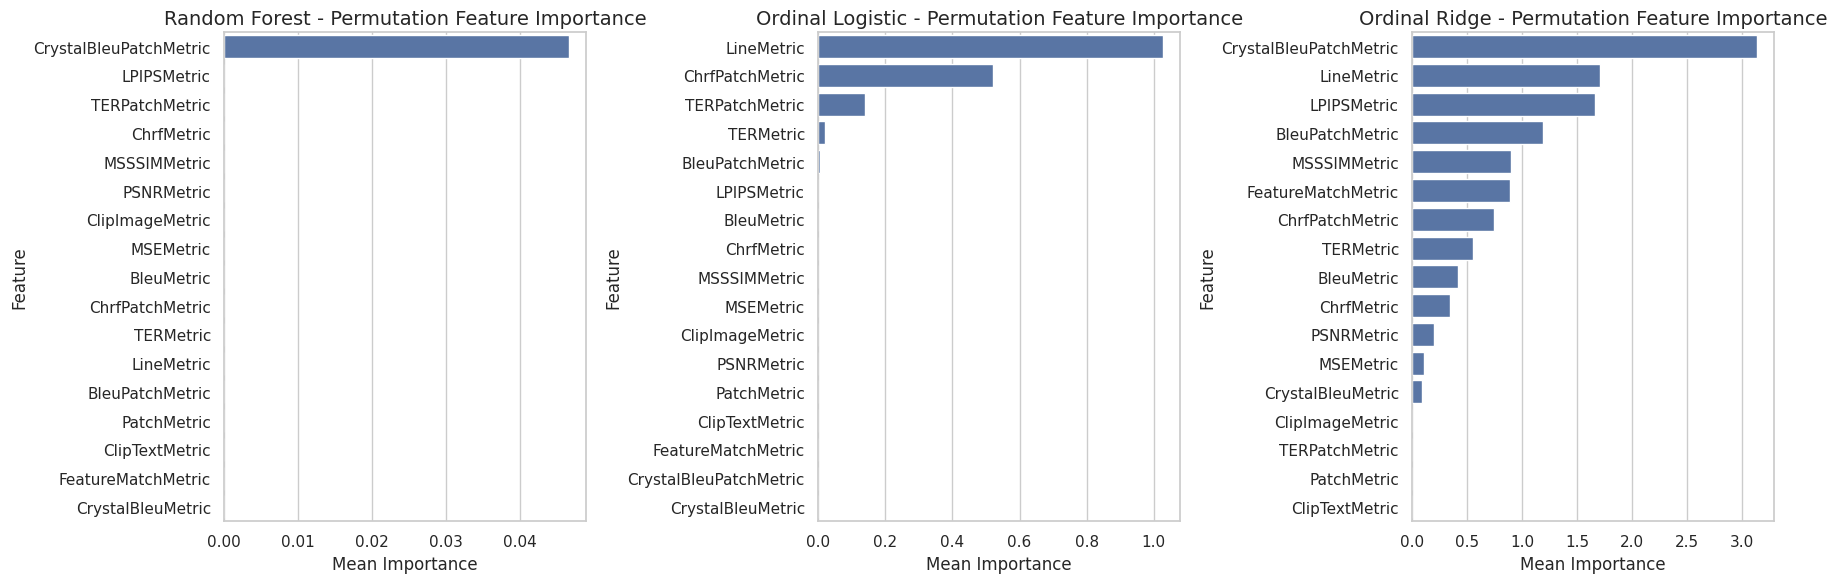

In [82]:
from mord import LogisticAT, OrdinalRidge 
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", message="X has feature names")
# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=123456),
    'Ordinal Logistic': LogisticAT(),
    'Ordinal Ridge': OrdinalRidge()
}

# Create a 1x3 grid of subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop over each model and plot its feature importance
for ax, (model_name, model) in zip(axes, models.items()):
    
    # Fit the model and calculate permutation importance
    model.fit(X, y)
    result = permutation_importance(model, X, y, n_repeats=10, random_state=123456)
    
    # Create DataFrame for the model's importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': result.importances_mean
    })
    
    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot on the corresponding axis
    sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax)
    ax.set_title(f'{model_name} - Permutation Feature Importance', fontsize=14)
    ax.set_xlabel('Mean Importance', fontsize=12)
    ax.set_ylabel('Feature', fontsize=12)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


#### Coefficient values of Logistic models

In [64]:
from mord import LogisticAT,OrdinalRidge 

ordinal_logit = LogisticAT()
ordinal_ridge = OrdinalRidge()
ordinal_logit.fit(X, y)
ordinal_ridge.fit(X, y)
ordinal_logit_scores = np.abs(ordinal_logit.coef_).flatten()  # Absolute value of coefficients
ordinal_ridge_scores = np.abs(ordinal_logit.coef_).flatten()  # Absolute value of coefficients
feature_names = X.columns


    
    # Create a DataFrame for better presentation and sorting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'logit_importance': ordinal_logit_scores,
    'ridge_importance': ordinal_ridge_scores
})


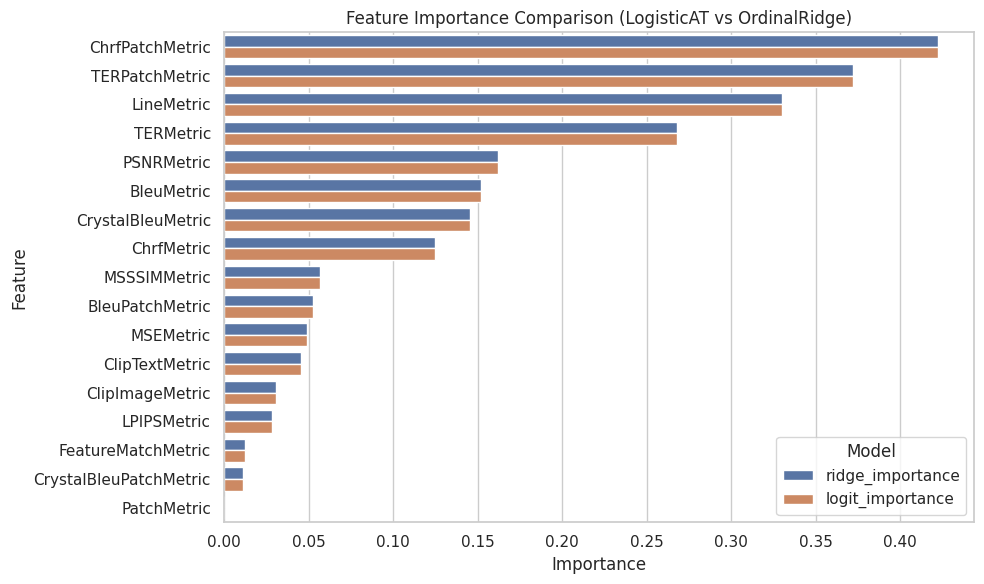

In [65]:
# Melt the DataFrame for seaborn plotting
importance_df = importance_df.melt(id_vars=['Feature'], var_name='Model', value_name='Importance')

# Sort values by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create the seaborn plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', hue='Model', orient='h')
plt.title('Feature Importance Comparison (LogisticAT vs OrdinalRidge)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()